# Wide & Deep Learning model 구현

저희는 추천 시스템을 적용하기 위해서 `Wide & Deep` 모델을 사용했습니다. 

모델 구현에 대한 간단한 설명을 하겠습니다.  
입력은 2개로 분리해서 생각하면 됩니다.  

`Wide 모델`의 입력: category Feature을 `Polynomial`하게 바꿔준 데이터  
`Deep 모델`의 입력: category Feature을 `embeding` 시켜준 데이터 + `continuous`한 데이터   
<br><br>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import os
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

## Data load

In [2]:
df_merge = pd.read_csv('./data/Total_Data_1.csv')
df_merge = df_merge[['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'biz_unit', 'sess_dt',
       'hit_tm', 'hit_pss_tm', 'trans_id', 'sech_kwd', 'tot_pag_view_ct',
       'tot_sess_hr_v', 'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1',
       'cum_act_2', 'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6','sech_clac_nm2',
       'cum_act_7', 'day', 'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp',
       'pty', 'r06', 'clac_nm2','clnt_gender', 'clnt_age']]

df_merge = df_merge.sort_values(['sess_dt', 'hit_tm'])
df_merge.loc[df_merge['clac_nm2'].isnull(),'clac_nm2'] = df_merge['sech_clac_nm2']
df_merge.head()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,holiday,hour,prefer_dvc_trfc,hum,temp,pty,r06,clac_nm2,clnt_gender,clnt_age
121082,3390,1,1,0,A01,2019-07-01,00:00,0,NaN,지고트,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Women's Outwear,unknown,unknown
194580,5535,1,1,5,A03,2019-07-01,00:00,6532,NaN,NaN,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,NaN,F,30
194581,5535,1,2,0,A03,2019-07-01,00:00,30494,NaN,양파,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Chilled Instant Foods,F,30
194582,5535,1,3,3,A03,2019-07-01,00:00,32370,NaN,NaN,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Chilled Beverages,F,30
194583,5535,1,4,0,A03,2019-07-01,00:00,41637,NaN,우엉,...,0,0,mobile_app_DIRECT,59.0,24.700001,0.0,0.0,Snacks,F,30


In [27]:
item_add_nm0 = pd.read_csv('./data/item_add_nm0.csv')
item_add_nm0 = item_add_nm0[['pd_c', 'clac_nm1']]

In [28]:
item_add_nm0['pd_c'] = item_add_nm0['pd_c'].astype(np.float).astype(str)

In [29]:
df3_trade = trade.merge(item_add_nm0, how = 'left')
df3_trade.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clac_nm1
0,2,42449.0,1,A02,1015.0,20190704,15:34,46430,1,Men's Clothing
1,2,62037.0,1,A03,92.0,20190729,23:47,36000,20,Beverages
2,2,64691.0,1,A03,186.0,20190731,21:25,3790,1,Chilled Foods
3,2,64691.0,2,A03,151.0,20190731,21:25,3990,1,Canned / Jarred Foods
4,2,64691.0,3,A03,351.0,20190731,21:25,4690,1,Dairy Products


In [58]:
sample_3 = pd.merge(df2_online, 
                     df3_trade, 
                on='trans_id', how='left')

In [59]:
sample_3 = sample_3[sample_3['clac_nm1'].notna()]

In [60]:
sample_3 = sample_3.sort_values('clac_nm1')

<br><br>
## label이 있는 행 추출

In [3]:
df_buyer = df_merge[(df_merge['action_type']==0)|(df_merge['action_type']==6)]
print('구매 이력이 있는 행:', round(len(df_buyer['clac_nm2']) / len(df_merge['clac_nm2']) * 100, 2),'%')

구매 이력이 있는 행: 24.55 %


In [4]:
del df_merge

<br><br>
## 데이터 전처리

### User2Vec 추가

In [5]:
# 유저 임베딩 데이터 load
user2vec = pd.read_csv('./data/user2vec100.csv')

In [6]:
df_buyer = df_buyer[df_buyer['clac_nm2'].notna()]
df_buyer = df_buyer.merge(user2vec, on=['clnt_id', 'sess_id'], how='left')

In [7]:
data = df_buyer.copy()

In [8]:
drop_col=['clnt_id', 'sess_id', 'hit_seq', 'action_type', 'hit_tm', 'trans_id','sech_clac_nm2', 'sess_dt', 'sech_kwd']
df_buyer = df_buyer.drop(drop_col, axis=1)

### <br><br>
## label 데이터 분리

In [9]:
le = LabelEncoder()

lab_len = len(df_buyer['clac_nm2'].value_counts())
label_key = df_buyer['clac_nm2'].value_counts().keys()

df_buyer['clac_nm2'] = le.fit_transform(df_buyer['clac_nm2'])
clac_nm2 = df_buyer['clac_nm2'].copy()
df_buyer.drop(['clac_nm2'], axis=1, inplace=True)

<br><br>
## 데이터 전처리

In [10]:
x_col = []
for i in range(100):
    x_col.append('X_'+str(i))

In [11]:
ALL_COLUMNS = [
    'biz_unit', 'hit_pss_tm', 'tot_pag_view_ct', 'tot_sess_hr_v',  
       'trfc_src', 'dvc_ctg_nm', 'cum_act_0', 'cum_act_1', 'cum_act_2',
       'cum_act_3', 'cum_act_4', 'cum_act_5', 'cum_act_6', 'cum_act_7', 'day',
       'holiday', 'hour', 'prefer_dvc_trfc', 'hum', 'temp', 'pty', 'r06',
       'clnt_gender', 'clnt_age'
]

CATEGORICAL_COLUMNS = [
    "biz_unit", 'trfc_src', 'dvc_ctg_nm',  
    'prefer_dvc_trfc', 'clnt_gender', 'clnt_age', 'pty'
]

EMBEDDED_COLUMNS = x_col

CONTINUOUS_COLUMNS = list(set(ALL_COLUMNS).difference(CATEGORICAL_COLUMNS+EMBEDDED_COLUMNS))

In [12]:
df_buyer.loc[df_buyer['clnt_gender'].isnull(),'clnt_gender'] = 'U'
df_buyer.loc[df_buyer['clnt_age'].isnull(),'clnt_age'] =  -1

In [13]:
for c in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    df_buyer[c] = le.fit_transform(df_buyer[c])

In [14]:
label = clac_nm2.copy()
label = np.eye(lab_len)[label]
label = pd.DataFrame(data=label, columns=label_key, index=df_buyer.index)

<br><br>
## Train 데이터, Test 데이터 분할

In [15]:
train_x, test_x , train_y , test_y = train_test_split(df_buyer , label , test_size=0.05, shuffle=False)

In [16]:
print('Train 데이터: ', train_x.shape)
print('Test 데이터: ', test_x.shape)
print('Train 라벨: ', train_y.shape)
print('Test 라벨: ', test_y.shape)

Train 데이터:  (626819, 124)
Test 데이터:  (32991, 124)
Train 라벨:  (626819, 309)
Test 라벨:  (32991, 309)


In [17]:
train_x, val_x , train_y , val_y = train_test_split(train_x , train_y , test_size=0.1, shuffle=False)

In [18]:
print('Train 데이터: ', train_x.shape)
print('Val 데이터: ', val_x.shape)
print('Train 라벨: ', train_y.shape)
print('Val 라벨: ', val_y.shape)

Train 데이터:  (564137, 124)
Val 데이터:  (62682, 124)
Train 라벨:  (564137, 309)
Val 라벨:  (62682, 309)


<br><br>
## Column 분할

In [19]:
train_x_category = np.array(train_x[CATEGORICAL_COLUMNS])
test_x_category  = np.array(test_x[CATEGORICAL_COLUMNS])
val_x_category   = np.array(val_x[CATEGORICAL_COLUMNS])

train_x_embedding = np.array(train_x[EMBEDDED_COLUMNS])
test_x_embedding  = np.array(test_x[EMBEDDED_COLUMNS])
val_x_embedding   = np.array(val_x[EMBEDDED_COLUMNS])

train_x_continue = np.array(train_x[CONTINUOUS_COLUMNS], dtype='float64')
test_x_continue = np.array(test_x[CONTINUOUS_COLUMNS], dtype='float64')
val_x_continue = np.array(val_x[CONTINUOUS_COLUMNS], dtype='float64')

<br><br>
## 정규화

In [20]:
scaler = StandardScaler()
train_x_continue = scaler.fit_transform(train_x_continue)
test_x_continue = scaler.transform(test_x_continue)
val_x_continue = scaler.transform(val_x_continue)

* 정규화 내용 확인

In [21]:
print(train_x_continue[0].sum())
print(train_x_continue[1].sum())
print(train_x_continue[2].sum())
print(train_x_continue[3].sum())
print(train_x_continue[4].sum())

-11.605023918592606
-11.354365361540133
-11.324531784106052
-11.31247193416602
-11.302824361617715


<br><br>
## Polynomial 적용
    - 카테고리 값을 Polynomial로 바꿔줌

* sklearn.preprocessing.PolynomialFeatures 메소드
    - degree : 다항식 차수
    - interaction_only
        - default는 False
        - ex) degree = 3일 때, interaction_only=false 이면
            - a^2, a^3, b^2, b^3, ab, a^2*b, ab^2 Feature가 추가되고,
        - interaction_only=True 이면
            - ab만 추가됨
        

In [22]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

In [23]:
train_x_category_poly = poly.fit_transform(train_x_category)
test_x_category_poly = poly.fit_transform(test_x_category)
val_x_category_poly = poly.fit_transform(val_x_category)

In [24]:
train_x_category_poly.shape

(564137, 29)

<br><br>
## 모델 구현

모델 구현에 대한 간단한 설명을 하겠습니다.  
입력은 2개로 분리해서 생각하면 됩니다.  

Wide 모델의 입력: category Feature을 Polynomial하게 바꿔준 데이터  
Deep 모델의 입력: category Feature을 embeding 시켜준 데이터 + continuous한 데이터  

그리고 출력은 lgbm 모델과 마찬가지로 1058개의 prediction 값이 row만큼 출력 됩니다.  

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import Model
import tensorflow.keras.backend as K

<br>

### 하이퍼 파라미터 튜닝

In [26]:
beta_1 = 0.9
lr = 1e-5
l1 = 0.01
l2 = 0.01
momentum = 0.99

<br>

In [27]:
def get_deep_model():
    
    category_inputs = []
    category_embeds = []
    
    # Categorical Data Embedding
    for i in range(len(CATEGORICAL_COLUMNS)):
        
        # input - embedding - flatten 순으로 layer 쌓기
        input_i = Input(shape=(1,), dtype='int32')
        
        dim = len(np.unique(df_buyer[CATEGORICAL_COLUMNS[i]]))
        
        embed_dim = int(np.ceil(dim ** 0.5))
        
        embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
        # dim : 데이터가 몇 종류 있는지 = 임베딩 벡터를 몇 개 뽑아낼 것인지
        # embed_dim : 임베딩 처리 후 벡터의 차원 = 임베딩 벡터를 몇 차원 벡터로 뽑아 낼 것인지
        # input_length : 입력 데이터 길이
        
        flatten_i = Flatten()(embed_i)
        # category 값을 임베딩환 벡터들을 flatten
        
        category_inputs.append(input_i)
        category_embeds.append(flatten_i)
        
    # continuous 데이터 input
    continue_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
    continue_dense = Dense(256, use_bias=False)(continue_input)
    
    # category와 continue를 합침
    concat_embeds = concatenate([continue_dense] + category_embeds)
    concat_embeds = Activation('relu')(concat_embeds)
    
    bn_concat = BatchNormalization(momentum=momentum)( concat_embeds)
    
    fc1 = Dense(512, use_bias=False)(bn_concat)
    relu1 = ReLU()(fc1)
    bn1 = BatchNormalization()(relu1)
    fc2 = Dense(256, use_bias=False)(bn1)
    relu2 = ReLU()(fc2)
    bn2 = BatchNormalization()(relu2)
    fc3 = Dense(128)(bn2)
    deep = ReLU()(fc3)
    
    return category_inputs, continue_input, deep

In [28]:
# x_train_category_poly : 카테고리 데이터를 숫자로 바꾸고, Poly Feature를 추가한 것
# Poly Feature : a, b, c Feature를 이용해서 ab, bc, ca Feature를 만든것
# 데이터의 shape 만 가져옴
def get_wide_model(poly):
    dim = poly.shape[1]
    return tf.keras.layers.Input(shape=(dim,))

def get_embed_model(embed):
    dim = embed.shape[1]
    return tf.keras.layers.Input(shape=(dim,))

In [29]:
# input - embedding - flatten 순으로 layer 쌓기
category_inputs, continue_input, deep_model = get_deep_model()
wide_model = get_wide_model(train_x_category_poly)
embed_model = get_embed_model(train_x_embedding)

<br><br>
### Wide모델과 Deep model을 합치기

In [30]:
concat = concatenate([deep_model, wide_model, embed_model])
inputs = [continue_input] + category_inputs + [wide_model] + [embed_model]
output = Dense(len(label_key), activation='sigmoid')(concat)
model = Model(inputs=inputs, outputs=output)

In [31]:
len(inputs)

10

<br><br>
### 입력 데이터

    * 위에서 정의한 리스트 변수 inputs에 맞추어
    * continue 데이터 => category 데이터 => poly data 순으로 입력 값을 넣어준다

In [32]:
input_data = [train_x_continue] + [train_x_category[:, i] \
             for i in range(train_x_category.shape[1])] + \
             [train_x_category_poly] + [train_x_embedding]

val_data = [val_x_continue] + [val_x_category[:, i] \
            for i in range(val_x_category.shape[1])] + \
            [val_x_category_poly] + [val_x_embedding]

<br><br>
## 학습 진행

In [33]:
def binary_crossentropy(y_true, y_pred):
    true = K.equal(y_true, 1.0 ) 
    true2 = K.cast(true , dtype = float)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

gamma = 2.0
epsilon = K.epsilon()

def focal_loss(y_true, y_pred):
    # https://www.kaggle.com/mathormad/resnet50-v2-keras-focal-loss-mix-up
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss
    return K.mean(K.sum(loss, axis=1))

model.compile(optimizer=tf.keras.optimizers.Adam(lr, beta_1=beta_1),
              loss=focal_loss   , # focal_loss  ,  # 'binary_crossentropy',
              metrics=[ binary_crossentropy ]) 

In [34]:
checkpoint_path = "./ckpt/my_checkpoint/KM-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor='val_loss',
                                                 save_best_only = True , 
                                                 save_freq = 'epoch' , 
                                                 mode='auto' ,
                                                 verbose=1)
# step 별로 learning rate를 조절합니다. 
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return tf.keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=lr, decay_factor=0.8, step_size=2)

  # `val_loss`가 2번의 에포크에 걸쳐 향상되지 않으면 훈련을 멈춥니다.
Early = tf.keras.callbacks.EarlyStopping(min_delta=0.0001, 
                                         patience=10 ,
                                         monitor='val_loss')

In [35]:
epochs = 500
batch_size = 128

In [36]:
history = model.fit(input_data, train_y, 
                  epochs=epochs, 
                  batch_size=batch_size, 
                  validation_data=(val_data, val_y), 
                  callbacks=[lr_sched, Early, cp_callback])

Epoch 1/500
4401/4408 [============================>.] - ETA: 0s - loss: 48.6831 - binary_crossentropy: 0.3033
Epoch 00001: val_loss improved from inf to 2.92667, saving model to ./ckpt/my_checkpoint/KM-0001.ckpt
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./ckpt/my_checkpoint/KM-0001.ckpt/assets
4408/4408 [==============================] - 15s 3ms/step - loss: 48.6174 - binary_crossentropy: 0.3029 - val_loss: 2.9267 - val_binary_crossentropy: 0.0716
Epoch 2/500
4395/4408 [============================>.] - ETA: 0s - loss: 2.4129 - binary_crossentropy: 0.0627
Epoch 00002: val_loss improved from 2.92667 to 2.13889, saving model to ./ckpt/my_checkpoint/KM-0002.ckpt
INFO:tensorflow:Assets written to: ./ckpt/my_checkpoint/KM-0002.ckpt/assets
4408/4408 [=================

In [37]:
model.save('./model/widendeep_model')

INFO:tensorflow:Assets written to: ./model/widendeep_model/assets


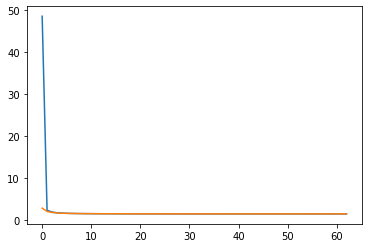

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

<br><br>
## 정확도 평가

In [40]:
# train input data와 같은 방식으로 test data를 input 형식에 맞추어줌
eval_input_data = [test_x_continue] + [test_x_category[:, i] for i in range(test_x_category.shape[1])] + [test_x_category_poly] + [test_x_embedding]

In [41]:
loss, acc = model.evaluate(eval_input_data, test_y)

1031/1031 [==============================] - 1s 1ms/step - loss: 1.5628 - binary_crossentropy: 0.0663


In [42]:
prob = model.predict(eval_input_data)

In [43]:
test_x = data.loc[test_x.index]

In [44]:
# one-hot에서 같은 trans_id는 더해줌.
receipt_y = test_y.copy()
receipt_y['trans_id'] = test_x['trans_id']
frame = pd.DataFrame(data = receipt_y['trans_id'], columns=['trans_id'])
receipt_y = receipt_y.groupby('trans_id', as_index=False).sum()
receipt_y = frame.merge(receipt_y, how='left').set_index(test_x.index)
receipt_y.drop('trans_id', axis=1, inplace=True)

In [45]:
receipt_y.head()

,Chilled Snacks,Snacks,Hot Snacks,Women's Upper Bodywear / Tops,Chilled Instant Foods,Bakery,Lighting Accessories,Biscuits,Ham and Sausages,Fish Cakes and Crab Sticks,...,Soccer / Footbal,Sea Food Gift Sets,Writing Supplies,Business Paper Products,Car Accessories,Grain Gift Sets,Car Wash Equipment,Vegetable Gift Sets,Improvement Supplies,Safety Equipment
626819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
626822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# 같은 영수증 별로 구매 아이템을 묶어주는 작업.
test_label = data.loc[test_x.index][['clnt_id','sess_id', 'clac_nm2']]
frame = pd.DataFrame(data = test_label[['clnt_id','sess_id']], columns=['clnt_id', 'sess_id'])
test_label = test_label.groupby(['clnt_id','sess_id'])['clac_nm2'].apply(lambda x: ', '.join(x))
test_label = frame.merge(test_label, on=['clnt_id', 'sess_id'],how='left').set_index(test_x.index)

In [47]:
test_label.head(18).tail(5)

,clnt_id,sess_id,clac_nm2
626832,31350,91,"Women's Lower Bodywear / Bottoms, Women's Lowe..."
626833,37794,114,"Traditional Rice Cakes, Hot Snacks"
626834,37794,114,"Traditional Rice Cakes, Hot Snacks"
626835,54771,40,"Fish Cakes and Crab Sticks, Girl's Toys, Chill..."
626836,54771,40,"Fish Cakes and Crab Sticks, Girl's Toys, Chill..."


In [48]:
score_pd = pd.DataFrame(prob, columns=receipt_y.columns)
cond = list(np.sum(receipt_y.values, axis=1) > 10)
cond_pd = score_pd[cond].reset_index(drop= True)
test_pd = test_label[cond].reset_index(drop= True)

In [49]:
''' 
pred_matrix: 예측된 아이템 행렬 파라미터.
top_n: 상위 몇개를 추천으로 사용할 지 정하는 파라미터.
test_matix: 고객ID와 Target이 있는 행렬 파라미터
'''
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    match_list = []
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        match = np.zeros(top_n).astype(np.int8).tolist()
        for j in range(len(top)):
            true_buy = [k for k in test_matix["clac_nm2"][i].split(', ')]
            if top[j] in true_buy :
                tmp += 1
                match[j] = 1
        match_list.append(match)
        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Accuracy of Top {}: {:>.3f}%\n".format(top_n, avg_acc*100))
    return avg_acc, match_list

In [50]:
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)
    
def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

In [89]:
accuracy, match_list =  get_acc(cond_pd, 5 , test_pd) 
map_val = mean_average_precision(match_list)
print("MAP: {:.3}%".format(map_val*100))

Accuracy of Top 5: 7.573%

MAP: 16.6%


<br><br>
## 결과 시각화

In [52]:
def get_pred_list(predict_y, top_n, target_matrix):
    test_matrix = target_matrix.copy()
    pred_matrix = predict_y.copy()
    for i in range(len(pred_matrix)):
        top = pred_matrix.iloc[i].nlargest(top_n).index
        top = pd.DataFrame(top.astype(str).to_frame().apply(lambda x: ", ".join(x)))
        test_matrix.loc[i, 'pred'] = top.values[0]
    return test_matrix

In [53]:
d={'word': clac_nm2, 'label': data['clac_nm2']}
df = pd.DataFrame(data=d).drop_duplicates()
cate2papago = df.set_index('label').to_dict()

In [115]:
test = get_pred_list(cond_pd, 10, test_pd)

In [116]:
test = test.groupby('sess_id', as_index=False).first()

In [117]:
def id_to_item(test, column_name):
    item_list = []
    for i in range(test.shape[0]):
        tmp_list = []
        for a in test.iloc[i][column_name].split(', '):
            tmp_list.append(a)
        item_list.append(tmp_list)
    return item_list

In [118]:
test

,sess_id,clnt_id,clac_nm2,pred
0,1,7090,"Instant Noodles, Dried Noodles, Dried Noodles,...","Hand / Foot Care, Mushrooms, Travel Bags, Frui..."
1,2,63998,"Chilled Instant Foods, Lighting Accessories, F...","Fruit Vegetables, Leaf Vegetables, Travel Bags..."
2,3,60449,"Packaged Side Dishes, Bakery, Hot Snacks, Seas...","Hand / Foot Care, Travel Bags, Fitness Trainin..."
3,4,30297,"Eggs, Processed Seaweeds, Processed Seaweeds, ...","Fruit Vegetables, Hand / Foot Care, Traditiona..."
4,5,24029,"Chilled Snacks, Chilled Snacks, Bakery, Chille...","Fitness Training, Leaf Vegetables, Hand / Foot..."
...,...,...,...,...
75,130,45092,"Ham and Sausages, Chilled Snacks, Ham and Saus...","Hand / Foot Care, Girls' Outwear, Fruit Vegeta..."
76,134,15518,"Biscuits, Processed Milk, Frozen Instant Foods...","Safety Equipment, Hand / Foot Care, Fruit Vege..."
77,138,35673,"Mushrooms, Yogurt, Biscuits, Frozen Instant Fo...","Fruit Vegetables, Kids' Underwear, Leaf Vegeta..."
78,196,62232,"Leaf Vegetables, Frozen Instant Foods, Tissues...","Fruit Vegetables, Girls' Outwear, Hand / Foot ..."


In [119]:
def remove_dup(li):
        my_set = set()
        res = []
        for e in li:
            if e not in my_set:
                res.append(e)
                my_set.add(e)
        return res

In [120]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    match_list = []
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        match = np.zeros(top_n).astype(np.int8).tolist()
        for j in range(len(top)):
            true_buy = [k.split(", ")[0] for k in test_matix["clac_nm2"][i].split()]
            if top[j] in true_buy :
                tmp += 1
                match[j] = 1
        match_list.append(match)
        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)
    print("Hit rate of Top {}: {:>.5f}".format(top_n, avg_acc))
    return avg_acc, match_list

In [121]:
def show_with_table(a, b, index):
    buy_list = remove_dup(a[index])
    rec_list = remove_dup(b[index])
    tmp=[]
    match = np.zeros(len(b[index])).astype(np.int8).tolist()
    for j in range(len(rec_list)):
        if rec_list[j] in buy_list :
            tmp.append(rec_list[j])
            match[j] = 1
    df1 = pd.DataFrame({"They buy": buy_list})
    df2 = pd.DataFrame({"We recommend" : rec_list})
    df = pd.concat([df1, df2], axis=1, sort=False)
    
    print(index, "번째 로그 데이터에 대한 결과\n")
    display(df)
    for t, i in enumerate(tmp):
        print("{}번째 추천 적중 상품 - {}".format(t, i))
    print("\nAP:", average_precision(match))

In [122]:
def find_good_case(a, b, criteria=0.5):
    good_map=[]
    for index in range(len(a)):
        buy_list = remove_dup(a[index])
        rec_list = remove_dup(b[index])
        match = np.zeros(len(b[index])).astype(np.int8).tolist()
        for j in range(len(rec_list)):
            if rec_list[j] in buy_list :
                match[j] = 1
        good_map.append(average_precision(match))
    best_idx = []
    for idx, v in enumerate(good_map):
        if v >= criteria:
            best_idx.append(idx)
    return best_idx

In [123]:
a = id_to_item(test, 'clac_nm2')
b = id_to_item(test, 'pred')

In [124]:
good_case_idx = find_good_case(a, b, 0.5)

In [125]:
show_with_table(a,b, 24)

24 번째 로그 데이터에 대한 결과



,They buy,We recommend
0,Books,Fruit Vegetables
1,Snacks,Girls' Outwear
2,Musical Instruments,Hand / Foot Care
3,Yogurt,Skis / Snowboards
4,Domestic Fruits,Travel Bags
5,Fruit Vegetables,Leaf Vegetables
6,Leaf Vegetables,Kids' Tableware
7,Mushrooms,Women's General Sport Clothing
8,Domestic Porks,Fruit and Vegetable Drinks
9,NaN,Dessert


0번째 추천 적중 상품 - Fruit Vegetables
1번째 추천 적중 상품 - Leaf Vegetables

AP: 0.6666666666666666


<br><br>
## Entropy Diversity 
- 추천 결과가 얼마나 분산 되어 있느냐를 평가

In [108]:
import math
ideal = 'abcde'
probid = [ float(ideal.count(c)) / len(ideal) for c in dict.fromkeys(list(ideal))]
entropy_ideal = - sum([ p * math.log(p) / math.log(2.0) for p in probid ])

In [109]:
entropy_ideal = - sum([ p * math.log(p) for p in probid])
entropy_ideal

1.6094379124341005

In [110]:
def entropy_diversity(li):
    total = []
    for first_list in li:
        for items in first_list:
            total.append(items)
    total_unique = list(set(total))
    probid = [ float(total.count(c)) / len(total) for c in total_unique]
    entropy_ideal = - sum([ p * math.log(p) for p in probid])
    return entropy_ideal

In [111]:
entropy_diversity(b)

2.6985442459601057